In [16]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Mini-project 1: Dealing with sparse rewards in the Mountain Car environment

In [2]:
environment = gym.make('MountainCar-v0', render_mode = "rgb_array")

## 2 First steps

In [35]:
class RandomAgent():
    def __init__(self, initial_state):
        self.state = initial_state

    def observe(self, state, action, next_state, reward):
        None
    def select_action(self, state):
        return environment.action_space.sample()
    def update(self):
        None

def run_episode(agent, render=False, video_path="video.mp4"):

    state, _ = environment.reset()
    agent = agent(state)
    done = False
    
    episode_reward = 0
    duration = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = environment.action_space.sample()
        next_state, reward, terminated, truncated, _ = environment.step(action)

        episode_reward += reward
        duration += 1
        
        state = next_state
        done = terminated or truncated
    if render:
        out.release()
    return episode_reward, duration

In [36]:
list_total_rewards, list_durations = ([], [])

for episode in range(100):
    if (episode==1): kwargs = dict(render=True)
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode(RandomAgent, **kwargs)
    list_total_rewards.append(total_reward)
    list_durations.append(duration)

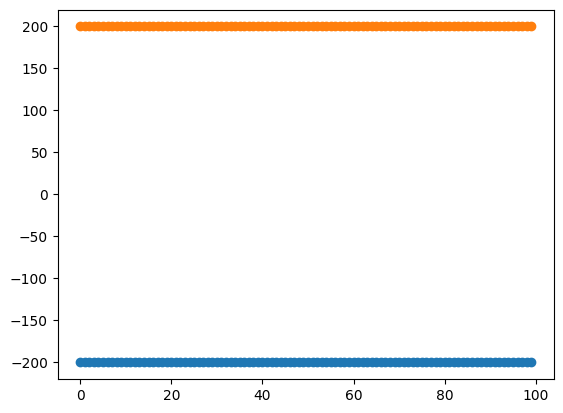

In [37]:
plt.scatter(np.arange(100), list_total_rewards)
plt.scatter(np.arange(100), list_durations)
plt.show()

## 3 DQN